# **308386804**
# **204434906**

## **Imports & Installations**

In [ ]:
pip install keras-swa

In [ ]:
!pip install scikit-posthocs

In [ ]:
try:
    from google import colab
    !pip3 install optuna==0.14.0
    !pip install optkeras==0.0.7
except:
    print('Run in non-Colab environment.')

     |████████████████████████████████| 92kB 9.1MB/s  eta 0:00:01
     |████████████████████████████████| 81kB 8.4MB/s 
     |████████████████████████████████| 174kB 35.5MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 112kB 46.2MB/s 
     |████████████████████████████████| 143kB 46.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
  Created wheel for optuna: filename=optuna-0.14.0-cp37-none-any.whl size=125710 sha256=be990eb35ca0bb37cd6761e7dd2ad800cd2d7481a74487c8aba9c36b2589af8f
  Stored in directory: /root/.cache/pip/wheels/4f/5f/2b/3c699d0425d8f34f8a81dfebe30f4d2b9f19377f41c57dbae3
  Created wheel for typing: filename=typing-3.7.4.3-cp37-none-any.whl size=26323 sha256=57c0089b6a9075fab819d5ff84f79f601e41f38cfdc5c058ffac76f5bfe3832f
  Stored in directory: /root/.cache/pip/wheels/2d/04/41/8e1836e79581989c22eebac3f4e70aaac9af07b0908da173be
  Created wheel for pyperclip:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import os
import math
import timeit
import random
from numpy.random import seed
from numpy.random import randn
from scipy.stats import friedmanchisquare
from matplotlib import pyplot as plt

from swa.tfkeras import SWA

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint



from sklearn.model_selection import train_test_split
from sklearn import metrics
import scikit_posthocs as sp
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold, StratifiedKFold


import optuna

from optkeras.optkeras import OptKeras

%matplotlib inline

## **Global Variables**

In [ ]:
path = r'/content/drive/MyDrive/classification_datasets'
output_path = r'/content/drive/MyDrive/ML_Project'

train_nes_X = ''
train_nes_Y = ''
valid_X = ''
valid_Y = ''
N_FEATURES = ''
N_CLASSES = ''

#This is The index of the Full_DF Table - start 1 -> 600
Iter = 1

Dataset_names = ['abalon', 'wall-following' , 'car' , 'wine-quality-white' , 'steel-plates' , 'yeast' , 'annealing' , 'wine-quality-red' , 'waveform' , 'statlog-image',
         'cardiotocography-3clases' , 'blood' , 'monks-1' , 'credit-approval' , 'pima' , 'musk-1' , 'mushroom' , 'chess-krvkp' , 'diabetes' , 'pm10']
Binary_datasets = ['blood' , 'monks-1' , 'credit-approval' , 'pima' , 'musk-1' , 'mushroom' , 'chess-krvkp' , 'diabetes' , 'pm10']

Full_DF = pd.DataFrame(columns=['Dataset Name' , 'Algorithm Name', 'Cross Validation [1-10]', 'Hyper-Parameters Values',
                                'Accuracy', 'TPR', 'FPR', 'Precision', 'AUC', 'PR-Curve', 'Training Time', 'Inference Time'])

OK = ''

In [ ]:
def Delete_All_H5_Files():
    files_in_directory = os.listdir(r'/content')
    filtered_files = [file for file in files_in_directory if file.endswith(".h5")]
    for file in filtered_files:
        path_to_file = os.path.join(r'/content', file)
        os.remove(path_to_file)
   

## **Improvement**


### **Cosine Aneealing Function**

In [6]:
def cosine_lr(curr_epoch, num_epochs, num_cycles, lr_swa_max):
    epochs_per_cycle = int(num_epochs/num_cycles)
    cos_inner = (math.pi * (curr_epoch % epochs_per_cycle)) / (epochs_per_cycle)
    return lr_swa_max/2 * (math.cos(cos_inner) + 1)

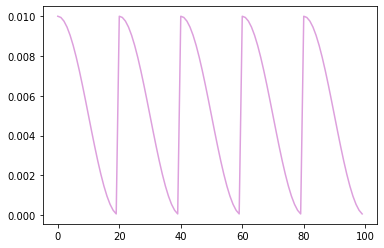

In [7]:
n_epochs = 100
n_cycles = 5
lrate_max = 0.01
series = [cosine_lr(i, n_epochs, n_cycles, lrate_max) for i in range(n_epochs)]
plt.plot(series, color='plum')
plt.show()

### **SWA Callback With Our Improvement**

In [ ]:
""" SWA Improved Callback
"""
def create_swa_callback_class(K, Callback, BatchNormalization):
    """Injecting library dependencies"""
    class SWA_Improved(Callback):
        """Stochastic Weight Averging.
        # Paper
            title: Averaging Weights Leads to Wider Optima and Better Generalization
            link: https://arxiv.org/abs/1803.05407

        # Arguments
            start_epoch:   integer, epoch when swa should start.
            lr_schedule:   'cosin' - string, type of learning rate schedule.
            swa_lr:        float, start learning rate for swa.
            swa_lr2:       float, upper bound of cosin learning rate.
            swa_freq:      integer, length of learning rate cycle.
            batch_size     integer, batch size (for batch norm with generator)
            verbose:       integer, verbosity mode, 0 or 1.
        """

        def __init__(
            self,
            start_epoch,
            lr_schedule="cosin",
            swa_lr="auto",
            swa_lr2="auto",
            swa_freq=1,
            batch_size=None,
            verbose=0,
        ):
            super(SWA_Improved, self).__init__()
            self.start_epoch = start_epoch - 1
            self.lr_schedule = 'cosin'
            self.swa_lr = swa_lr

            # if no user determined upper bound, make one based off of the lower bound
            self.swa_lr2 = swa_lr2 if swa_lr2 is not None else 10 * swa_lr
            self.swa_freq = swa_freq
            self.batch_size = batch_size
            self.verbose = verbose

            if start_epoch < 2:
                raise ValueError('"swa_start" attribute cannot be lower than 2.')
            schedules = ["cosin"]
            if self.lr_schedule not in schedules:
                raise ValueError('"{}" is not a valid learning rate schedule'.format(self.lr_schedule))

            if self.lr_schedule == "cosin" and self.swa_freq < 2:
                raise ValueError('"swa_freq" must be higher than 1 for cyclic schedule.')

            if self.swa_lr == "auto" and self.swa_lr2 != "auto":
                raise ValueError('"swa_lr2" cannot be manually set if "swa_lr" is automatic.')

            if (self.swa_lr != "auto" and self.swa_lr2 != "auto" and self.swa_lr > self.swa_lr2):
                raise ValueError('"swa_lr" must be lower than "swa_lr2".')

        def on_train_begin(self, logs=None):
            self.lr_record = []
            self.epochs = self.params.get("epochs")
            self.n_cycles = self.epochs / self.swa_freq
            if self.start_epoch >= self.epochs - 1:
                raise ValueError('"swa_start" attribute must be lower than "epochs".')
            self.init_lr = K.eval(self.model.optimizer.lr)
            # automatic swa_lr
            if self.swa_lr == "auto":
                self.swa_lr = 0.1 * self.init_lr
            if self.init_lr < self.swa_lr:
                raise ValueError('"swa_lr" must be lower than rate set in optimizer.')
            # automatic swa_lr2 between initial lr and swa_lr
            if self.lr_schedule == "cosin" and self.swa_lr2 == "auto":
                self.swa_lr2 = self.swa_lr + (self.init_lr - self.swa_lr) * 0.25
            self._check_batch_norm()
            if self.has_batch_norm and self.batch_size is None:
                raise ValueError('"batch_size" needs to be set for models with batch normalization layers.')

        def on_epoch_begin(self, epoch, logs=None):
            self.current_epoch = epoch
            self._scheduler(epoch)
            if self.is_swa_start_epoch: ## when we get to start epoch we save the pre-train model weights in W_swa
                self.swa_weights = self.model.get_weights()
                if self.verbose > 0:
                    print("\nEpoch %05d: starting stochastic weight averaging" % (epoch + 1))
            if self.is_batch_norm_epoch: ## when it batch normalization epoch we will update the W model weights with W_swa weights so far
                self._set_swa_weights(epoch)
                if self.verbose > 0:
                    print("\nEpoch %05d: reinitializing batch normalization layers" % (epoch + 1))
                self._reset_batch_norm()
                if self.verbose > 0:
                  print("\nEpoch %05d: running forward pass to adjust batch normalization" % (epoch + 1))

        def on_batch_begin(self, batch, logs=None):
            # update lr each batch for cosin lr schedule
            if self.lr_schedule == "cosin":
                self._update_lr(self.current_epoch, batch)
            if self.is_batch_norm_epoch:
                batch_size = self.batch_size
                momentum = batch_size / (batch * batch_size + batch_size)
                for layer in self.batch_norm_layers:
                    layer.momentum = momentum

        def on_epoch_end(self, epoch, logs=None):
            if self.is_swa_start_epoch: ## if we start SWA
                self.swa_start_epoch = epoch
            if self.is_swa_epoch and not self.is_batch_norm_epoch: ## if this is a SWA epoch and cycle is ending we need to update W_swa weights by averaging all the cycle ensamble models 
                self.swa_weights = self._average_weights(epoch)

        def on_train_end(self, logs=None):
            if not self.has_batch_norm:
                self._set_swa_weights(self.epochs)
            else:
                self._restore_batch_norm()
            for batch_lr in self.lr_record:
                self.model.history.history.setdefault("lr", []).append(batch_lr)

        def _scheduler(self, epoch):
            swa_epoch = epoch - self.start_epoch # get the current swa epoch, and
            self.is_swa_epoch = (epoch >= self.start_epoch and swa_epoch % self.swa_freq == 0)  ##check if it after the start epoch and if it is the end of cycle
            self.is_swa_start_epoch = epoch == self.start_epoch ## check if this is the swa start epoch
            self.is_batch_norm_epoch = epoch == self.epochs - 1 and self.has_batch_norm ## check if this is a batch_norm epoch

        def _average_weights(self, epoch):
              return [ ( swa_w * ( (epoch - self.start_epoch) / self.swa_freq) + w ) / ( ( epoch - self.start_epoch ) + 1 ) for swa_w, w in zip( self.swa_weights, self.model.get_weights() ) ]

        def _update_lr(self, epoch, batch=None):
            if self.is_batch_norm_epoch:
                lr = 0
                K.set_value(self.model.optimizer.lr, lr)
            elif self.lr_schedule == "cosin":
                lr = cosine_lr(epoch, self.epochs, self.swa_freq , self.swa_lr2)
                K.set_value(self.model.optimizer.lr, lr)
            self.lr_record.append(lr)

        # this function calculate the cosin learning rate schedualer
        def cosine_lr(curr_epoch, num_epochs, num_cycles, lr_swa_max):
            epochs_per_cycle = int(num_epochs/num_cycles)
            cos_inner = (math.pi * (curr_epoch % epochs_per_cycle)) / (epochs_per_cycle)
            return lr_swa_max/2 * (math.cos(cos_inner) + 1)

        ## update the model with the new W_swa weights
        def _set_swa_weights(self, epoch):
            self.model.set_weights(self.swa_weights)
            if self.verbose > 0:
                print("\nEpoch %05d: final model weights set to stochastic weight average" % (epoch + 1))

        def _check_batch_norm(self):

            self.batch_norm_momentums = []
            self.batch_norm_layers = []
            self.has_batch_norm = False
            self.running_bn_epoch = False

            for layer in self.model.layers:
                if issubclass(layer.__class__, BatchNormalization):
                    self.has_batch_norm = True
                    self.batch_norm_momentums.append(layer.momentum)
                    self.batch_norm_layers.append(layer)
            if self.verbose > 0 and self.has_batch_norm:
                print("Model uses batch normalization. SWA will require last epoch to be a forward pass and will run with no learning rate")

        def _reset_batch_norm(self):
            for layer in self.batch_norm_layers:
                # to get properly initialized moving mean and moving variance weights
                # we initialize a new batch norm layer from the config of the existing
                # layer, build that layer, retrieve its reinitialized moving mean and
                # moving var weights and then delete the layer
                bn_config = layer.get_config()
                new_batch_norm = BatchNormalization(**bn_config)
                new_batch_norm.build(layer.input_shape)
                new_moving_mean, new_moving_var = new_batch_norm.get_weights()[-2:]
                # get rid of the new_batch_norm layer
                del new_batch_norm
                # get the trained gamma and beta from the current batch norm layer
                trained_weights = layer.get_weights()
                new_weights = []
                # get gamma if exists
                if bn_config["scale"]:
                    new_weights.append(trained_weights.pop(0))
                # get beta if exists
                if bn_config["center"]:
                    new_weights.append(trained_weights.pop(0))
                new_weights += [new_moving_mean, new_moving_var]
                # set weights to trained gamma and beta, reinitialized mean and variance
                layer.set_weights(new_weights)

        def _restore_batch_norm(self):
            for layer, momentum in zip(
                self.batch_norm_layers, self.batch_norm_momentums
            ):
                layer.momentum = momentum

    return SWA_Improved

## **Main Functions**

In [ ]:
def CalculateAllScores(fold, y_test, pred_Y, pred_prob_Y, binaryClassifier=False):
    global Full_DF, Iter
    print("CalculateAllScores")
    if binaryClassifier is True:
        TN, FP, FN, TP = metrics.confusion_matrix(y_test, pred_Y).ravel()
        auc = metrics.roc_auc_score(y_test, pred_prob_Y)
        pr_curve = metrics.average_precision_score(y_test, pred_prob_Y)

    else:
        cm = metrics.confusion_matrix(y_test, pred_Y)
        FP = cm.sum(axis=0) - np.diag(cm) 
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)
        FP = np.mean(FP.astype(float))
        FN = np.mean(FN.astype(float))
        TP = np.mean(TP.astype(float))
        TN = np.mean(TN.astype(float))
        auc= metrics.roc_auc_score(y_test, pred_prob_Y, multi_class='ovr')
        y_test_hot = pd.get_dummies(y_test.astype(str))
        pr_curve = metrics.average_precision_score(y_test_hot, pred_prob_Y)

    Full_DF.loc[Iter, 'Accuracy'] = round((TP+TN)/(TP+FP+FN+TN), 3)
    Full_DF.loc[Iter, 'TPR'] = round(TP/(TP+FN), 3)
    Full_DF.loc[Iter, 'FPR'] = round(FP/(FP+TN), 3)
    Full_DF.loc[Iter, 'Precision'] = round(TP/(TP+FP), 3)
    Full_DF.loc[Iter, 'AUC'] = round(auc, 3)
    Full_DF.loc[Iter, 'PR-Curve'] = round(pr_curve, 3)


In [ ]:
def Get_Model(model_name, best_params):
    if model_name == 'SGD':
        model = Sequential()
        model.add(Dense(128 ,activation='relu', input_shape=(N_FEATURES,), name='Dense128_Layer'))
        model.add(Dense(64 ,activation='relu', input_shape=(N_FEATURES,), name='Dense64_Layer'))
        model.add(Dense(32 ,activation='relu', input_shape=(N_FEATURES,), name='Dense32_Layer'))
        model.add(Dense(16 ,activation='relu', input_shape=(N_FEATURES,), name='Dense16_Layer'))
        model.add(Dropout(best_params["dropout_rate"], name="Dropout_Layer"))
        if N_CLASSES == 2:
            model.add(Dense(1,activation='sigmoid', name="Output_Layer"))
            model.compile(loss='binary_crossentropy', 
                    optimizer=SGD(learning_rate=best_params["learning_rate"]), 
                    metrics=['accuracy'])
        else:
            model.add(Dense(N_CLASSES,activation='softmax', name="Output_Layer"))
            model.compile(loss='categorical_crossentropy', 
                    optimizer=SGD(learning_rate=best_params["learning_rate"]), 
                    metrics=['accuracy'])
        return model
    if model_name in ['SWA' , 'SWA_Improved']:
        model = Sequential()
        model.add(Dense(128 ,activation='relu', input_shape=(N_FEATURES,), name='Dense128_Layer'))
        model.add(BatchNormalization())
        model.add(Dense(64 ,activation='relu', input_shape=(N_FEATURES,), name='Dense64_Layer'))
        model.add(BatchNormalization())
        model.add(Dense(32 ,activation='relu', input_shape=(N_FEATURES,), name='Dense32_Layer'))
        model.add(BatchNormalization())
        model.add(Dense(16 ,activation='relu', input_shape=(N_FEATURES,), name='Dense16_Layer'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5, name="Dropout_Layer"))
        if N_CLASSES == 2:
            model.add(Dense(1,activation='sigmoid', name="Output_Layer"))
            model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=best_params["learning_rate"]), metrics=['accuracy'])
        else:
            model.add(Dense(N_CLASSES,activation='softmax', name="Output_Layer"))
            model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=best_params["learning_rate"]), metrics=['accuracy'])
        return model

In [ ]:
def objectiveSWA(trial):
    K.clear_session()
    model = Sequential()
    model.add(Dense(128 ,activation='relu', input_shape=(N_FEATURES,), name='Dense128_Layer'))
    model.add(BatchNormalization())
    model.add(Dense(64 ,activation='relu', input_shape=(N_FEATURES,), name='Dense64_Layer'))
    model.add(BatchNormalization())
    model.add(Dense(32 ,activation='relu', input_shape=(N_FEATURES,), name='Dense32_Layer'))
    model.add(BatchNormalization())
    model.add(Dense(16 ,activation='relu', input_shape=(N_FEATURES,), name='Dense16_Layer'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, name="Dropout_Layer"))
    if N_CLASSES == 2:
        model.add(Dense(1,activation='sigmoid', name="Output_Layer"))
        model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate=trial.suggest_loguniform("learning_rate", 1e-3, 3e-3)), 
                  metrics=['accuracy'])
    else:
        model.add(Dense(N_CLASSES,activation='softmax', name="Output_Layer"))
        model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(learning_rate=trial.suggest_loguniform("learning_rate",1e-3, 3e-3)), 
                  metrics=['accuracy'])
    swa = SWA(start_epoch=12, lr_schedule='cyclic', 
            swa_lr=trial.suggest_loguniform("swa_lr", 1e-3, 3e-3), 
            swa_lr2=trial.suggest_loguniform("swa_lr2",3e-3, 6e-3), 
            swa_freq=trial.suggest_int("swa_freq", 2, 4), 
            batch_size=32)
    cp = tf.keras.callbacks.ModelCheckpoint('SWA_Model_trial_{}.h5'.format(trial.number), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    if N_CLASSES == 2:
        model.fit(train_nes_X, train_nes_Y, validation_data=(valid_X, valid_Y), epochs=18, callbacks=[cp, swa])
    else:
        model.fit(train_nes_X, to_categorical(train_nes_Y, N_CLASSES), validation_data=(valid_X, to_categorical(valid_Y, N_CLASSES)), epochs=18, callbacks=[cp, swa])
    return OK.trial_best_value

def objectiveSWAIMP(trial):
    K.clear_session()
    model = Sequential()
    model.add(Dense(128 ,activation='relu', input_shape=(N_FEATURES,), name='Dense128_Layer'))
    model.add(BatchNormalization())
    model.add(Dense(64 ,activation='relu', input_shape=(N_FEATURES,), name='Dense64_Layer'))
    model.add(BatchNormalization())
    model.add(Dense(32 ,activation='relu', input_shape=(N_FEATURES,), name='Dense32_Layer'))
    model.add(BatchNormalization())
    model.add(Dense(16 ,activation='relu', input_shape=(N_FEATURES,), name='Dense16_Layer'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5, name="Dropout_Layer"))
    if N_CLASSES == 2:
        model.add(Dense(1,activation='sigmoid', name="Output_Layer"))
        model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate=trial.suggest_loguniform("learning_rate", 1e-3, 3e-3)), 
                  metrics=['accuracy'])
    else:
        model.add(Dense(N_CLASSES,activation='softmax', name="Output_Layer"))
        model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(learning_rate=trial.suggest_loguniform("learning_rate",1e-2, 3e-2)), 
                  metrics=['accuracy'])
    swa = SWA(start_epoch=12, lr_schedule='cyclic', 
            swa_lr=trial.suggest_loguniform("swa_lr", 1e-3, 3e-3), 
            swa_lr2=trial.suggest_loguniform("swa_lr2",3e-3, 6e-3), 
            swa_freq=trial.suggest_int("swa_freq", 2, 4), 
            batch_size=32)
    cp = tf.keras.callbacks.ModelCheckpoint('SWA_Improved_Model_trial_{}.h5'.format(trial.number), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    if N_CLASSES == 2:
        model.fit(train_nes_X, train_nes_Y, validation_data=(valid_X, valid_Y), epochs=18, callbacks=[cp, swa])
    else:
        model.fit(train_nes_X, to_categorical(train_nes_Y, N_CLASSES), validation_data=(valid_X, to_categorical(valid_Y, N_CLASSES)), epochs=18, callbacks=[cp, swa])
    return OK.trial_best_value
  
def objectiveSGD(trial):
    K.clear_session()
    model = Sequential()
    model.add(Dense(128 ,activation='relu', input_shape=(N_FEATURES,), name='Dense128_Layer'))
    model.add(Dense(64 ,activation='relu', input_shape=(N_FEATURES,), name='Dense64_Layer'))
    model.add(Dense(32 ,activation='relu', input_shape=(N_FEATURES,), name='Dense32_Layer'))
    model.add(Dense(16 ,activation='relu', input_shape=(N_FEATURES,), name='Dense16_Layer'))
    model.add(Dropout(trial.suggest_uniform("dropout_rate", 0.1, 1.0), name="Dropout_Layer"))
    if N_CLASSES == 2:
        model.add(Dense(1,activation='sigmoid', name="Output_Layer"))
        model.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate=trial.suggest_loguniform("learning_rate",1e-3, 3e-3)), 
                  metrics=['accuracy'])
    else:
        model.add(Dense(N_CLASSES,activation='softmax', name="Output_Layer"))
        model.compile(loss='categorical_crossentropy', 
                  optimizer=SGD(learning_rate=trial.suggest_loguniform("learning_rate", 1e-3, 3e-3)), 
                  metrics=['accuracy'])
    cp = tf.keras.callbacks.ModelCheckpoint('SGD_Model_trial_{}.h5'.format(trial.number), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    if N_CLASSES == 2:
        model.fit(train_nes_X, train_nes_Y, validation_data=(valid_X, valid_Y), epochs=18, callbacks=[cp])
    else:
        model.fit(train_nes_X, to_categorical(train_nes_Y, N_CLASSES), validation_data=(valid_X, to_categorical(valid_Y, N_CLASSES)), epochs=18, callbacks=[cp])
    return OK.trial_best_value

In [ ]:
def CrossValidationRandomSearch(model_name, dataset_name, X, Y, binaryClassifier=False):
    global train_nes_X, train_nes_Y, valid_X, valid_Y, N_FEATURES, N_CLASSES, Full_DF, Iter
    global OK
    stratified_kfold = StratifiedKFold(n_splits=10 , shuffle = True , random_state = 9051993)
    print("## Start 10 Fold Croos Validation ##")
    k = 1
    for train_index, test_index in stratified_kfold.split(np.zeros(len(Y)),Y):
        Full_DF.loc[Iter, 'Cross Validation [1-10]'] = k
        Full_DF.loc[Iter, 'Dataset Name'] = dataset_name
        Full_DF.loc[Iter, 'Algorithm Name'] = model_name
        print("\tStart Fold Number {}".format(k))
        train_X = X.iloc[train_index]
        train_Y = Y.iloc[train_index]
        test_X = X.iloc[test_index].values
        test_Y = Y.iloc[test_index]
        N_FEATURES = train_X.shape[1]
        N_CLASSES = len(np.unique(train_Y))
        print(np.unique(train_Y) , np.unique(test_Y))
        nested_kfold = StratifiedKFold(n_splits=3 , shuffle = True , random_state = 3535656)
        start_nested_kfold = timeit.default_timer()
        best_params = []
        best_values = []
        
        OK = OptKeras(study_name='3Folds Hyper-Parameters',
              monitor='val_acc',
              direction='maximize',
              random_grid_search_mode=True)

        for train_nested_index, valid_index in stratified_kfold.split(np.zeros(len(train_Y)),train_Y):
            train_nes_X = train_X.iloc[train_nested_index].values
            train_nes_Y = train_Y.iloc[train_nested_index]
            valid_X = train_X.iloc[valid_index].values
            valid_Y = train_Y.iloc[valid_index]
            if model_name == 'SWA_Improved':
                OK.random_grid_search(objectiveSWAIMP , n_trials=int(50))
            elif model_name == 'SWA':
                OK.random_grid_search(objectiveSWA, n_trials=int(50))
            else:
                OK.random_grid_search(objectiveSGD, n_trials=int(50))
            best_params.append(OK.best_trial.params)
            best_values.append(OK.best_trial.value)
            OK.print_results

        stop_nested_kfold = timeit.default_timer()
        Full_DF.loc[Iter, 'Training Time'] = stop_nested_kfold - start_nested_kfold
        max_acc = max(best_values)
        fold_num = best_values.index(max_acc)
        s = ''
        for key in best_params[fold_num]:
            s += "{}: {} | ".format(key , best_params[fold_num][key])
        Full_DF.loc[Iter, 'Hyper-Parameters Values'] = s

        best_model = Get_Model(model_name, best_params[fold_num])
        best_model.load_weights("{}_Model_trial_{}.h5".format(model_name,OK.best_trial.number))
        
        start_predict = timeit.default_timer()
        if N_CLASSES == 2:
            results = best_model.evaluate(test_X, test_Y, N_CLASSES)
        else:
            results = best_model.evaluate(test_X, to_categorical(test_Y, N_CLASSES))
        print(results)
        stop_predict = timeit.default_timer()
        Full_DF.loc[Iter, 'Inference Time'] = stop_predict - start_predict
        pred_prob_Y = best_model.predict_proba(test_X)
        pred_Y = Get_Class_From_Probs(pred_prob_Y, binaryClassifier)
        CalculateAllScores(k, test_Y, pred_Y, pred_prob_Y, binaryClassifier)
        Delete_All_H5_Files()
        Iter += 1
        k += 1
        print("")

In [ ]:
def Get_Class_From_Probs(pred_prob_Y, isBinary):
    if isBinary:
        rounded = [round(x[0]) for x in pred_prob_Y]
        return rounded
    df = pd.DataFrame(pred_prob_Y)
    df['Max'] = df.idxmax(axis=1)
    return df['Max']

In [ ]:
def Import_DataSets_To_DataFrame(df_name):
    current_path = os.path.join(path, df_name + ".csv")
    df = pd.read_csv(current_path)
    df.sample(frac=1)
    X = df[df.columns[:-1]]
    Y = df.iloc[: , -1:]
    return df_name,X,Y

## **Running All Datasets - Each Cell Run 4**

In [ ]:
from sklearn.model_selection import train_test_split
for n in Dataset_names:
    isBinary=False
    name,X,y = Import_DataSets_To_DataFrame(n)
    if n in Binary_datasets:
        isBinary=True
    if n == 'diabetes':
        y.replace({"tested_positive": 0, "tested_negative": 1}, inplace=True)
    if n == 'pm10':
        y.replace({"P": 0, "N": 1}, inplace=True)
    print("\n##########################################################\n\t{}\n##########################################################\n".format(name))
    print(y.shape , X.shape)
    if len(X) >= 3000:
        X, xx, y, yy = train_test_split(X, y, test_size=0.5, random_state=15482)
    Details_swa_imp = CrossValidationRandomSearch('SGD', name, X , y, binaryClassifier=isBinary)
    Details_swa_imp = CrossValidationRandomSearch('SWA', name, X , y, binaryClassifier=isBinary)
    Details_swa_imp = CrossValidationRandomSearch('SWA_Improved', name, X , y, binaryClassifier=isBinary)
    Full_DF.to_csv(os.path.join(output_path, 'Full_DF_{}.csv'.format(name)))

## **Friedman Test**

In [ ]:
df_all_avg = df.groupby(['Dataset Name' , 'Algorithm Name'])['AUC'].mean().reset_index(name='avg_AUC')
df_SGD = df_all_avg[df_all_avg['Algorithm Name']== 'SGD']
df_SWA = df_all_avg[df_all_avg['Algorithm Name']== 'SWA']
df_SWA_Imp = df_all_avg[df_all_avg['Algorithm Name']== 'SWA_Improved']
df_SGD

In [ ]:
df_SWA

In [ ]:
df_SWA_Imp

In [ ]:
# Friedman test

# seed the random number generator
seed(1)

# compare samples
stat, p = friedmanchisquare(df_SGD['avg_AUC'], df_SWA['avg_AUC'], df_SWA_Imp['avg_AUC'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=24.700, p=0.000
Different distributions (reject H0)


## **Post Hoc Neime Test**

In [ ]:

#combine three groups into one array
data = np.array([df_SGD['avg_AUC'], df_SWA['avg_AUC'], df_SWA_Imp['avg_AUC']])

#perform Nemenyi post-hoc test
sp.posthoc_nemenyi_friedman(data.T)

,0,1,2
0,1.000,0.001000,0.001000
1,0.001,1.000000,0.781714
2,0.001,0.781714,1.000000


In [ ]:
# Note: We had to transpose the numpy array (data.T) in order to perform the post-hoc test correctly.

# The Nemeyi post-hoc test returns the p-values for each pairwise comparison of means. From the output we can see the following p-values:

# P-value of group 0 vs. group 1: 0.001
# P-value of group 0 vs. group 2: 0.001
# P-value of group 1 vs. group 2: 0.7817

# At α = .05, the only two groups that have statistically significantly different means are group 1 and group 2.

# Note: The Nemenyi test converted the group number from 1, 2, 3 into 0, 1, 2. Thus, the groups from the original data that are significantly different are groups 2 and 3.

In [ ]:
df_all_avg = df.groupby(['Dataset Name' , 'Algorithm Name']).agg({'Accuracy':'mean', 'TPR' : 'mean', 'FPR': 'mean', 'AUC' : 'mean','PR-Curve':'mean','Training Time':'mean',	'Inference Time':'mean'})
df_all_avg.to_csv("avg_of_all_datasets.csv")
df_all_avg

Accuracy  ...  Inference Time
Dataset Name             Algorithm Name            ...                
abalon                   SGD               0.7594  ...        0.324497
                         SWA               0.7626  ...        0.535491
                         SWA_Improved      0.7583  ...        0.404932
annealing                SGD               0.8804  ...        0.314779
                         SWA               0.8960  ...        0.493562
                         SWA_Improved      0.9060  ...        0.388661
blood                    SGD               0.7512  ...        0.271395
                         SWA               0.7635  ...        0.411998
                         SWA_Improved      0.7514  ...        0.534545
car                      SGD               0.8449  ...        0.233531
                         SWA               0.9133  ...        0.393195
                         SWA_Improved      0.9790  ...        0.437133
cardiotocography-3clases SGD               0.8562  ...        0.431383
                         SWA               0.9085  ...        0.580247
                         SWA_Improved      0.9210  ...        0.405737
chess-krvkp              SGD               0.6552  ...        0.429200
                         SWA               0.8861  ...        0.742345
                         SWA_Improved      0.8788  ...        0.561552
credit-approval          SGD               0.6365  ...        0.363076
                         SWA               0.8060  ...        0.453382
                         SWA_Improved      0.8103  ...        0.588629
diabetes                 SGD               0.6311  ...        0.345622
                         SWA               0.6912  ...        0.504392
                         SWA_Improved      0.6703  ...        0.484657
monks-1                  SGD               0.5644  ...        0.371452
                         SWA               0.6369  ...        0.505213
                         SWA_Improved      0.6387  ...        0.361654
mushroom                 SGD               0.9258  ...        0.548844
                         SWA               0.9912  ...        1.017440
                         SWA_Improved      0.9950  ...        0.818809
musk-1                   SGD               0.6173  ...        0.359246
                         SWA               0.7009  ...        0.403216
                         SWA_Improved      0.7179  ...        0.509284
pima                     SGD               0.6626  ...        0.366516
                         SWA               0.7042  ...        0.480134
                         SWA_Improved      0.7133  ...        0.582985
pm10                     SGD               0.5020  ...        0.300492
                         SWA               0.4720  ...        0.495893
                         SWA_Improved      0.4700  ...        0.386349
statlog-image            SGD               0.8345  ...        0.292269
                         SWA               0.9631  ...        0.490845
                         SWA_Improved      0.9753  ...        0.446406
steel-plates             SGD               0.8500  ...        0.313204
                         SWA               0.9079  ...        0.504082
                         SWA_Improved      0.9214  ...        0.395611
wall-following           SGD               0.7626  ...        0.248053
                         SWA               0.8454  ...        0.381726
                         SWA_Improved      0.9137  ...        0.438176
waveform                 SGD               0.7294  ...        0.292376
                         SWA               0.8526  ...        0.480645
                         SWA_Improved      0.8977  ...        0.388715
wine-quality-red         SGD               0.8393  ...        0.316341
                         SWA               0.8545  ...        0.489220
                         SWA_Improved      0.8688  ...        0.427227
wine-quality-white       SGD               0.7779  ...        0.3